In [15]:
import pandas as pd
import numpy as np
from common_variables import *
import wave_process
# import ta_feature
from tqdm import tqdm
import matplotlib.pyplot as plt
import joblib
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import  *
from tensorflow.keras.callbacks import EarlyStopping
# from time_series import df_to_X_y2future,df_to_X_y2
from tradingview_ta import TA_Handler, Interval, Exchange
import yfinance as yf
import talib as ta


In [16]:
def df_to_X_y2(df, window_size=6):
    print(df.shape)
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][:4]
        y.append(label)
    X=np.asarray(X)
    y=np.asarray(y)
    print(f"hii X {X.shape}, y {y.shape}")
    return X,y


In [17]:

def technicalIndicators(data):
    # print(data)
    data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data['Close'], \
                                                                 fastperiod=7, slowperiod=14, signalperiod=5)
  
    data['CCI14'] = ta.CCI(data['High'], data['Low'], data['Close'], timeperiod=14)
   

    
    data['ATR14'] = ta.ATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data['NATR14']=ta.NATR(data['High'], data['Low'], data['Close'], timeperiod=14)
    data["DEMA"]=ta.DEMA(data['Close'], timeperiod=14)

    data["BBupper"],data["BBmidle"],data["BBlower"]=ta.BBANDS(data['Close'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    data["EMA10"]=ta.EMA(data['Close'], timeperiod=10)
    data["EMA30"]=ta.EMA(data['Close'], timeperiod=30)
    data["MOM"] = ta.MOM(data['Close'], timeperiod=14)
    data["MA"]=ta.MA(data['Close'], timeperiod=14, matype=0)
    data['ROc']=ta.ROC(data['Close'], timeperiod=28)
    data["WillR"]=ta.WILLR(data['High'], data['Low'], data['Close'], timeperiod=14)
    # data["Pattern"]=ta.CDLCOUNTERATTACK(data['Open'],data['High'], data['Low'], data['Close'])



    return data


In [18]:

def getdata(ticker):
# Get the data
    data = yf.download(tickers=ticker+"=X",period="730d" ,interval="1h",progress=True)
    data=data.drop(["Adj Close","Volume"],axis=1)
    data['Close_wave'],data['High_wave'],data['Low_wave'],\
    data['Open_wave']=wave_process.denoising([data['Close'],data['High'],data['Low'],data['Open']])
    data=technicalIndicators(data)
    data.dropna(how='any', inplace=True)
    data = data[data.shape[0] % batch_size:]
    validation_size1=round(data.shape[0]/6)
    test_size1=validation_size1
    test_size1

    df_train =data[:- validation_size1*2]
    df_validation = data[- validation_size1*2 :- test_size1]
    df_test = data[- test_size1 :]
    print(f'df_train.shape {df_train.shape}, df_validation.shape {df_validation.shape}, df_test.shape {df_test.shape}')
    return df_train,df_validation,df_test,data





In [19]:

def preprocess(df_train,df_test,df_validation,scaler = StandardScaler()):

    
    train_values=df_train.iloc[:,:]
    val_values=df_validation.iloc[:,:]
    test_values=df_test.iloc[:,:]
    train_values.iloc[:,:] = scaler.fit_transform(train_values)[:,:]
    val_values.iloc[:,:]=scaler.fit_transform(val_values)[:,:]
    test_values.iloc[:,:]=scaler.fit_transform(test_values)[:,:]
    X,y=df_to_X_y2(train_values,window_size)
    x_val,y_val=df_to_X_y2(val_values,window_size)
    x_test,y_test=df_to_X_y2(test_values,window_size)

    return X,y,x_val,y_val,x_test,y_test,train_values,val_values,test_values,scaler


In [20]:

# def getmodel():        
#     model = Sequential()
#     forward_layer = GRU(128, return_sequences=True,kernel_regularizer=tf.keras.regularizers.L1(0.02))
#     backward_layer = LSTM(64, return_sequences=True, go_backwards=True)
#     model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(12, 24)))
#     model.add(Conv1D(64, kernel_size=2))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32,return_sequences = True))
#     model.add(Conv1D(64, kernel_size=2))
#     model.add(Flatten())
#     model.add(Dense(8))
#     model.add(RepeatVector(2))
#     model.add(TimeDistributed(Dense(4)))
    


#     model.compile(
#         optimizer='sgd',
#         loss='mse',
#         metrics=[tf.keras.metrics.RootMeanSquaredError(),"acc"])
#     model.build()

#     print(model.summary())
#     return model

def getmodel():        
    model = Sequential()
    forward_layer = GRU(128, return_sequences=True,kernel_regularizer=tf.keras.regularizers.L1(0.02))
    backward_layer = LSTM(64, return_sequences=True, go_backwards=True)
    model.add(Bidirectional(forward_layer, backward_layer=backward_layer, input_shape=(24, 24)))
    model.add(Conv1D(64, kernel_size=2))
    model.add(Dropout(0.2))
    model.add(LSTM(32,return_sequences = True))
    model.add(Conv1D(64, kernel_size=2))
    model.add(Flatten())
    model.add(Dense(8))
    model.add(Dense(4))
    


    model.compile(
        optimizer='sgd',
        loss='mse',
        metrics=[tf.keras.metrics.RootMeanSquaredError(),"acc"])
    model.build()

    print(model.summary())
    return model

In [21]:
import time
import os.path


  
# # store starting time
# begin = time.time()
ticker="gbpusd"
df_train,df_val,df_test,data=getdata(ticker)
epochs = 50
np.random.seed(seed)
tf.random.set_seed(seed)

file_exists = os.path.exists('readme.txt')
# if file_exists:
#     xtrain,ytrain,xval,yval,ttable,vtable,scaler=preprocess(df_train=df_train,df_validation=df_validation)
#     model = tf.keras.models.load_model(model_path)
# else:
xtrain,ytrain,xval,yval,xtest,ytest,ttable,valtble,testtble,scaler=preprocess(df_train=df_train,df_validation=df_val,df_test=df_test)

[*********************100%***********************]  1 of 1 completed
df_train.shape (11520, 24), df_validation.shape (2880, 24), df_test.shape (2880, 24)


C:\Users\harsh\AppData\Local\Temp\ipykernel_12456\503210406.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_values.iloc[:,:] = scaler.fit_transform(train_values)[:,:]
C:\Users\harsh\AppData\Local\Temp\ipykernel_12456\503210406.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_values.iloc[:,:]=scaler.fit_transform(val_values)[:,:]
C:\Users\harsh\AppData\Local\Temp\ipykernel_12456\503210406.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

(11520, 24)
hii X (11496, 24, 24), y (11496, 4)
(2880, 24)
hii X (2856, 24, 24), y (2856, 4)
(2880, 24)
hii X (2856, 24, 24), y (2856, 4)


In [22]:

model=getmodel()
history=model.fit(xtrain, ytrain,validation_data=(xval, yval), epochs = epochs,batch_size=batch_size, shuffle=False,verbose=2,callbacks=EarlyStopping(monitor='val_loss', patience=3))
# model.save(model_path)
# joblib.dump(scaler, scaler_path) 

# total time taken


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirectio  (None, 24, 192)          81920     
 nal)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 23, 64)            24640     
                                                                 
 dropout_2 (Dropout)         (None, 23, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 23, 32)            12416     
                                                                 
 conv1d_5 (Conv1D)           (None, 22, 64)            4160      
                                                                 
 flatten_2 (Flatten)         (None, 1408)              0         
                                                      

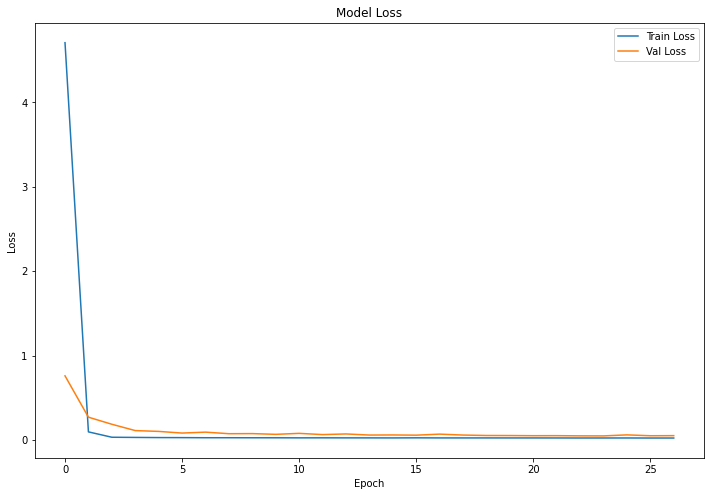

In [24]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.subplots(1)
ax1.set_title('Model Loss')
ax1.set(xlabel='Epoch', ylabel='Loss')
ax1.plot(history.history['loss'][:], label='Train Loss')
ax1.plot(history.history['val_loss'][:], label='Val Loss')
ax1.legend()

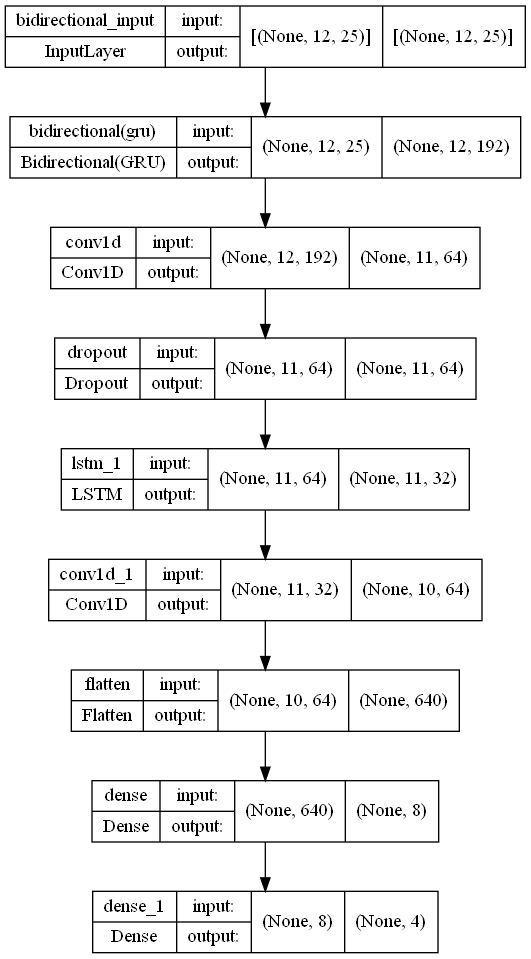

In [34]:
# from keras.utils.vis_utils import plot_model
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [25]:
mse = model.evaluate(xval, yval, verbose=1)
print("Mean Squared Error:", mse)

90/90 [==============================] - 2s 8ms/step - loss: 0.0511 - root_mean_squared_error: 0.1776 - acc: 0.3025
Mean Squared Error: [0.05111842229962349, 0.17759686708450317, 0.3025210201740265]


In [26]:
y_pred = model.predict(xtest)
y_true= np.reshape(ytest, (ytest.shape[0], 4))


In [27]:
y_pred

array([[ 0.9158102 ,  0.9252427 ,  0.92006445,  0.8969574 ],
       [ 0.9109751 ,  0.9221926 ,  0.9258418 ,  0.90035814],
       [ 0.9156335 ,  0.91653955,  0.9340113 ,  0.91096795],
       ...,
       [-1.9658774 , -2.0104134 , -1.9785277 , -1.9962195 ],
       [-1.9933993 , -2.0325365 , -2.0049431 , -2.026821  ],
       [-2.0029242 , -2.0318403 , -2.0154953 , -2.0296597 ]],
      dtype=float32)

In [28]:
y_true.shape

(2856, 4)

In [29]:

forcaste=np.repeat(y_pred,24,axis=1)
real=np.repeat(y_true,24,axis=1)
forcaste=forcaste[:,:24]
real=real[:,:24]
y_pred=scaler.inverse_transform(forcaste)[:,3]
y_true=scaler.inverse_transform(real)[:,3]

In [30]:
y_true

array([1.35020739, 1.34896764, 1.3483122 , ..., 1.28291446, 1.28298033,
       1.28340881])

In [31]:
y_pred

array([1.3528945, 1.3527989, 1.3528911, ..., 1.2958674, 1.2953229,
       1.2951343], dtype=float32)

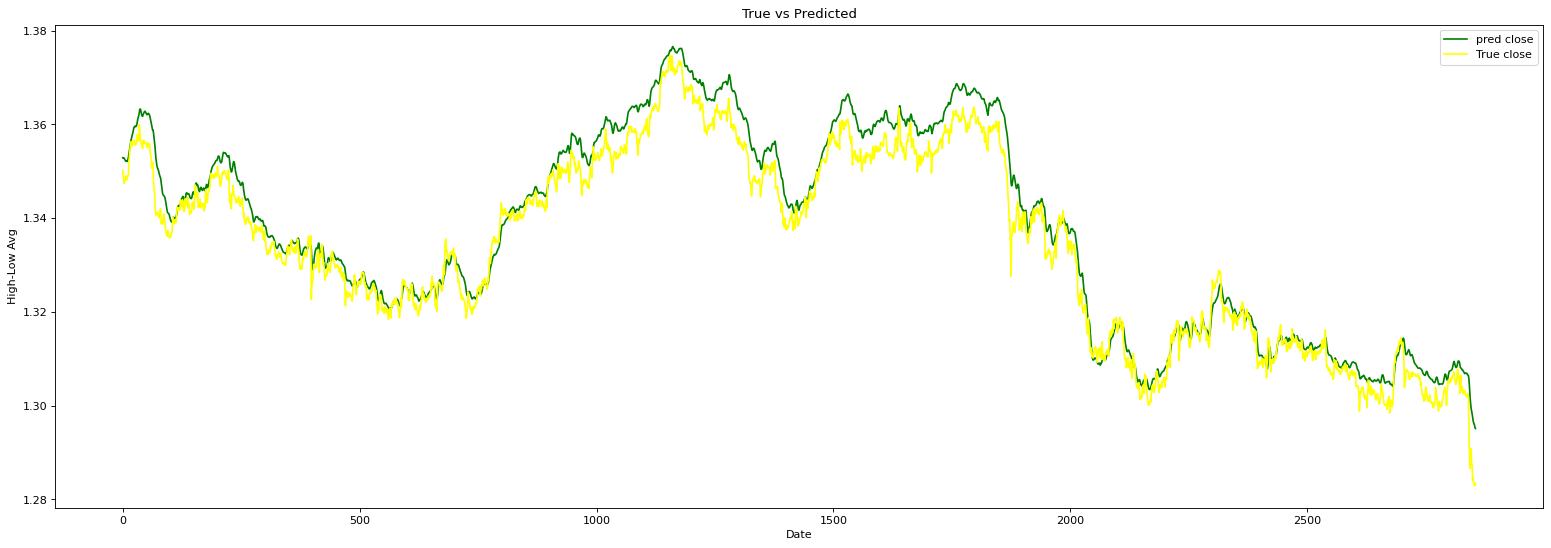

In [32]:
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
temp_df={"y_pred":y_pred,"y_true":y_true}
plt.plot(temp_df["y_pred"], color = 'green', label = 'pred close')
plt.plot(temp_df["y_true"], color = 'yellow', label = 'True close')
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()

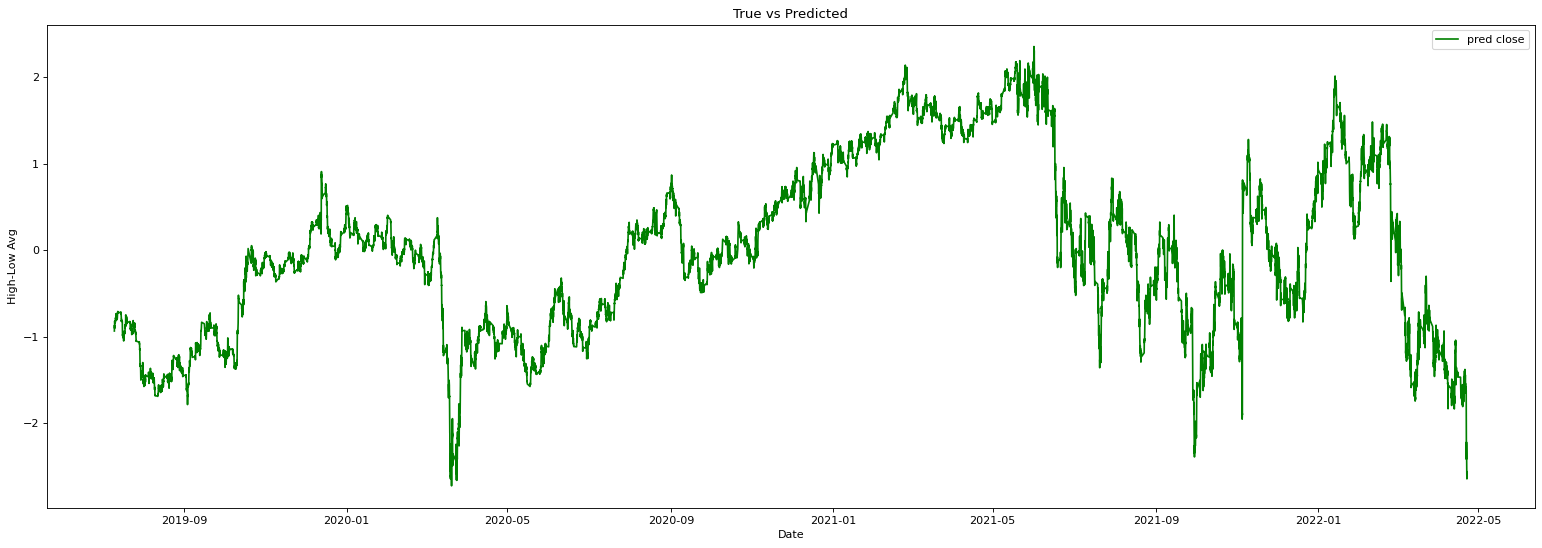

In [33]:
# y_true=yval
# # y_true= np.reshape(y_true, (y_true.shape[0], 1))
# # forcaste=np.repeat(y_pred,vtable.shape[1],axis=1)
# # real=np.repeat(y_true,vtable.shape[1],axis=1)
# y_pred=y_pred[:,0]
# y_true=scaler.inverse_transform(yval)[:,0]
plt.figure(figsize=(24, 8), dpi=80, facecolor='w', edgecolor='k')
# temp_df={"y_pred":y_pred,"y_true":y_true}
plt.plot(data["Close"], color = 'green', label = 'pred close')
# plt.plot(temp_df["y_true"], color = 'yellow', label = 'True close')
plt.title('True vs Predicted')
plt.xlabel('Date')
plt.ylabel('High-Low Avg')
plt.legend()
plt.show()

In [25]:
# def df_to_X_y2future(df, window_size=12,nfuture=0):
#     df_as_np = df.to_numpy()
#     X = []
#     y = []
#     r=len(df_as_np)-window_size-nfuture+1 if nfuture>1 else len(df_as_np)-window_size
#     for i in range(r):
#         row = [r for r in df_as_np[i:i+window_size]]
#         X.append(row)
#         label =[r for r in df_as_np[i+window_size:i+window_size+nfuture]] if nfuture>1 else df_as_np[i+window_size]
#         y.append(label)
#     return np.asarray(X), np.asarray(y)